In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, calculate_overlap
import torchvision
from models.generator import GeneratorRRDB
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548

In [4]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

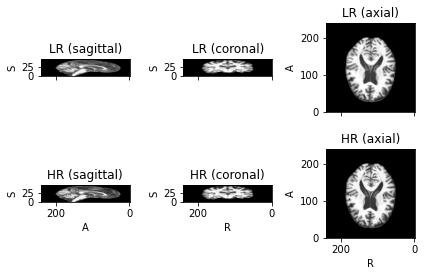

In [5]:
img_real = ImagePair(number=1, simulated=False, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

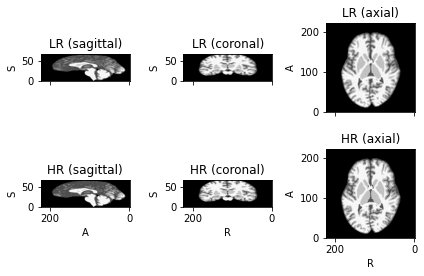

In [6]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [7]:
source = 'sim'

if source == 'sim':
    img = sim_set
elif source == 'real':
    img = real_set

In [23]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = torch.device("cpu")

config = {
    'alpha_adversarial': 1,
}
root = '/mnt/beta/djboonstoppel/Code/ray_results'
exp_name = 'alpha_adv-no_content'
epoch = 30
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(config['alpha_adversarial'], epoch)
path = os.path.join(root, exp_name, 'checkpoints', ckpt_fname)
# ckptpath = 'ray_results/alpha_adv/checkpoints'
# ckpt_filename = 'checkpoint_{}_{}_{}-best'.format(config['batch_size'], config['num_filters'], config['optimizer']
#                                            )

# model = LitTrainer_org.load_from_checkpoint(netG=generator,
#                                             netF=feature_extractor,
#                                             checkpoint_path=path)
model = LitTrainer_gan.load_from_checkpoint(netG=generator,
                                            netF=feature_extractor,
                                            netD=discriminator,
                                            checkpoint_path=path)
print(model.hparams)
model.to(device)
model.eval()
model.freeze()

"args":   Namespace(std=0.3548, num_workers=4, root_dir='/mnt/beta/djboonstoppel/Code', name='alpha_adv-no_content', num_samples=1, patch_size=64, warmup_batches=1000, logger=True, checkpoint_callback=None, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=-1, min_epochs=None, max_steps=-1, min_steps=None, max_time='00:20:00:00', limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accelerator=None, strategy=None, sync_batchnorm=False, precision=32, enable_model_summary=True, weights_

In [24]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)

In [25]:
subject = img[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

Inference time: 6.03 s


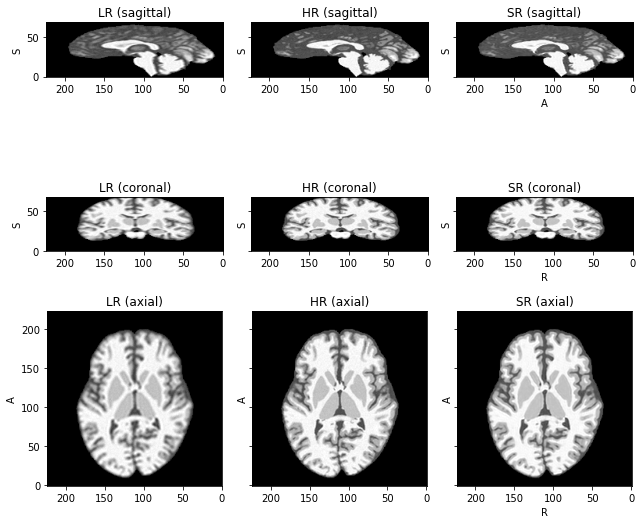

In [26]:
start_time = time.time()

aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()

end_time = time.time()
print('Inference time: {:.2f} s'.format(end_time - start_time))

generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'SR')
subject.plot(figsize=(9, 8))
torch.cuda.empty_cache()

In [27]:
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

if source == 'sim':
    img_source = img_sim
elif source == 'real':
    img_source = img_real

fname ='img_{}'.format(config['alpha_adversarial'])

output_path = os.path.join(root, exp_name, 'output', source)
os.makedirs(output_path, exist_ok=True)
# name='100206'
std = std
max_vals = (
    img_source.info()['LR']['scaling'],
    img_source.info()['HR']['scaling'],
    img_source.info()['LR']['scaling'],
    )
save_subject(subject=subject,
             header=img_source.info()['LR']['header'],
             pref=fname,
             std=std,
             max_vals=max_vals,
             path=output_path,
             source = source,
             )